- 分析 MD 模拟

    - 可视化

    - 均方根差

    - 氢键分析

In [1]:
# %pip install nglview

In [2]:
# %conda install mdanalysis

In [3]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nglview as nv
import MDAnalysis as mda
from MDAnalysis.analysis import rms, diffusionmap, align
from MDAnalysis.analysis.distances import dist
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA


/root/learn/nf-mol/.conda/lib/python3.11/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [4]:
HERE = Path(_dh[-1])
DATA = HERE / "data"


In [5]:
md_universe = mda.Universe(str(DATA / "topology.pdb"), str(DATA / "trajectory.xtc"))
view = nv.show_mdanalysis(md_universe)
view


NGLWidget(max_frame=99)

In [6]:
view.render_image(trim=True, factor=2, transparent=True)
view._display_image()

In [7]:
#  ------ 对齐 (Alignment) ------
#  在分子动力学模拟中，蛋白质会发生旋转和平移。
#  这会干扰视觉检查和数据分析。
#  对齐的目的是消除这些旋转和平移，使蛋白质保持相对固定的位置和方向。

# 设置轨迹指针到第一帧，作为参考帧。所有后续帧都将与此帧对齐。
md_universe.trajectory[
    0
]  # 将轨迹读取指针移动到第一帧 (索引为 0)。 这将作为对齐的参考结构。

# 使用 MDAnalysis 的 align.AlignTraj 类进行对齐
alignment = align.AlignTraj(
    mobile=md_universe,  # 要对齐的轨迹 (Universe 对象)
    reference=md_universe,  # 参考轨迹 (Universe 对象)。 这里使用同一个 Universe，意味着每帧都与第一帧对齐
    select="protein",  # 选择用于对齐的原子。 这里选择 "protein"，表示使用蛋白质的原子进行对齐
    in_memory=True,  # 是否将对齐后的轨迹保存在内存中。
    #  如果轨迹太大，无法全部加载到内存中，可以使用 in_memory=False，
    #  然后将对齐后的轨迹保存到文件中。
)

# 运行对齐
alignment.run()  # 执行对齐操作。  这会改变 `md_universe` 对象中的原子坐标，使其对齐。


In [8]:
# 对齐后的轨迹也可以重新显示出来，以便观察对齐效果
view = nv.show_mdanalysis(md_universe)  # 创建一个新的 nglview 对象，显示对齐后的轨迹
view


NGLWidget(max_frame=99)

In [9]:
# 渲染图片，并设置高质量、透明背景和自动裁剪
view.render_image(trim=True, factor=2, transparent=True);
#   - trim=True: 裁剪图片周围的空白区域，使分子结构更紧凑地显示。
#   - factor=2: 放大图片的分辨率，提高图片质量。  factor=2 表示分辨率是原来的两倍。
#   - transparent=True: 设置图片背景为透明，方便叠加到其他图片上。


In [10]:
# 显示渲染后的图片 (在某些环境下可能不需要，但在某些环境下是必需的)
view._display_image()
#   - 这个函数负责在 Jupyter Notebook 或类似的环境中显示渲染后的图片。
#   - 在某些情况下，即使调用了 view.render_image()，图片也可能不会自动显示，
#     这时就需要调用 view._display_image() 来确保图片显示出来。


In [11]:
# 保存为 HTML 文件
output_file = "md_visualization.html"
nv.write_html(output_file, [view], frame_range=[0, view.frame - 1])  # 设置帧数


## 蛋白质和配体的 RMSD
- 为了评估相对运动

In [12]:
ligand_name = "03P"


In [13]:
def rmsd_for_atomgroups(universe, selection1, selection2=None):
    """Calulate the RMSD for selected atom groups.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection1: str
        Selection string for main atom group, also used during alignment.
    selection2: list of str, optional
        Selection strings for additional atom groups.

    Returns
    -------
    rmsd_df: pandas.core.frame.DataFrame
        DataFrame containing RMSD of the selected atom groups over time.
    """

    universe.trajectory[0]
    ref = universe
    rmsd_analysis = rms.RMSD(
        universe, ref, select=selection1, groupselections=selection2
    )
    rmsd_analysis.run()
    columns = [selection1, *selection2] if selection2 else [selection1]
    rmsd_df = pd.DataFrame(
        np.round(rmsd_analysis.results.rmsd[:, 2:], 2), columns=columns
    )
    rmsd_df.index.name = "frame"
    return rmsd_df


In [14]:
# 分子将沿着蛋白质的主干叠加到第一帧
rmsd = rmsd_for_atomgroups(
    md_universe, "backbone", ["protein", f"resname {ligand_name}"]
)
rmsd.head()


,backbone,protein,resname 03P
frame,,,
0,0.00,0.00,0.00
1,0.83,1.12,1.72
2,0.96,1.28,1.62
3,0.99,1.36,1.57
4,1.03,1.44,1.51


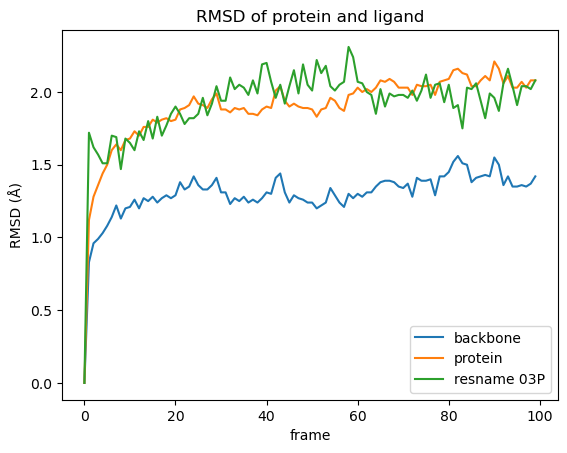

In [15]:
rmsd.plot(title="RMSD of protein and ligand")
plt.ylabel("RMSD (Å)");
#  分号 ; 的作用是阻止plt.ylabel()函数的返回值在 Jupyter Notebook 或类似交互式环境中被打印出来。


- 在模拟过程中，主链中仅发生了轻微的构象变化，这并不奇怪，因为蛋白质是相对于主链叠加的。

- 与仅计算蛋白质主链相比，将蛋白质侧链纳入 RMSD 计算中会导致更多的运动。

- 在我们的模拟中，配体的运动范围与蛋白质侧链相同。然而，情况并非总是如此，因为配体可以更自由地移动，而且除了任何构象变化外，还可能涉及定向运动。如果配体的 RMSD 值异常高，则很可能是这种情况。

## 帧间 RMSD

In [16]:
def RMSD_dist_frames(universe, selection):
    """Calculate the RMSD between all frames in a matrix.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection: str
        Selection string for the atomgroup to be investigated, also used during alignment.

    Returns
    -------
    array: np.ndarray
        Numpy array of RMSD values.
    """
    pairwise_rmsd = diffusionmap.DistanceMatrix(universe, select=selection)
    pairwise_rmsd.run()
    return pairwise_rmsd.results.dist_matrix


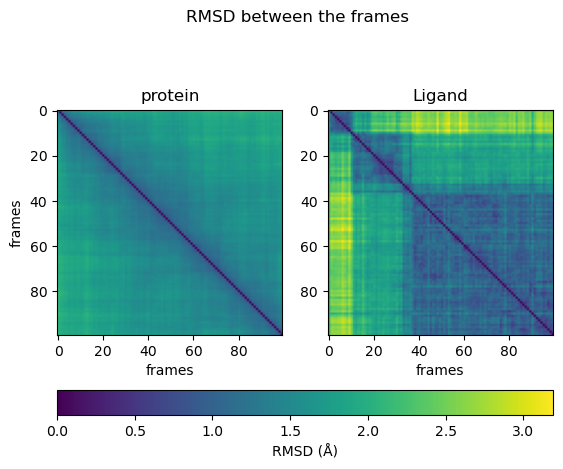

In [17]:
dist_matrix_protein = RMSD_dist_frames(md_universe, "protein")
dist_matrix_ligand = RMSD_dist_frames(md_universe, f"resname {ligand_name}")

# get maximal distance between all frames
max_dist = max(np.amax(dist_matrix_ligand), np.amax(dist_matrix_protein))

# figure with two subplots
fig, ax = plt.subplots(1, 2)
fig.suptitle("RMSD between the frames")

# protein image
img1 = ax[0].imshow(dist_matrix_protein, cmap="viridis", vmin=0, vmax=max_dist)
ax[0].title.set_text("protein")
ax[0].set_xlabel("frames")
ax[0].set_ylabel("frames")

# ligand image
img2 = ax[1].imshow(dist_matrix_ligand, cmap="viridis", vmin=0, vmax=max_dist)
ax[1].title.set_text("Ligand")
ax[1].set_xlabel("frames")

fig.colorbar(img1, ax=ax, orientation="horizontal", fraction=0.1, label="RMSD (Å)");


## 交互分析

In [18]:
# 配体周围 5 Å 半径内的所有残基均以可见的原子和键显示。

# select pocket residues
pocket_resids = set(
    md_universe.select_atoms(f"(around 5 resname {ligand_name}) and protein").resids
)
view2 = nv.show_mdanalysis(md_universe)
view2.add_representation(
    "licorice", selection=f"protein and ({' '.join([str(x) for x in pocket_resids])})"
)
view2.center(selection="ligand")
view2


NGLWidget(max_frame=99)

In [19]:
view2.render_image(trim=True, factor=2, transparent=True)
view2._display_image()

## 原子距离


In [20]:
# 我们想要观察蛋氨酸 793 的主链氮与配体的芳香环的紧密接触。

protein_residue_id = "793"
protein_atom_name = "N"
ligand_id = "1"
ligand_atom_name = "N4"


In [21]:
atomgroup_protein = md_universe.select_atoms(
    f"resid {protein_residue_id} and name {protein_atom_name}"
)
atomgroup_ligand = md_universe.select_atoms(
    f"resname {ligand_name} and name {ligand_atom_name}"
)
[i for i in atomgroup_ligand.atoms.names]


['N4']

In [22]:
# 现在，我们可以计算当前宇宙框架中原子之间的距离
# （使用distfrom 函数MDAnalysis）。该函数返回一个数组数组
# 前两个元素是残基 ID，但我们只对第三个条目感兴趣，即距离。
distance = dist(atomgroup_protein, atomgroup_ligand)
print(
    f"The distance between residues {protein_residue_id} and {ligand_id} is {distance[2][0]:.2f} Å"
)
# 3.5Å 的距离足够近，可以起到介导配体结合的作用，值得进一步研究。
# 我们刚刚测量的配体与蛋氨酸 793 主链氮之间的相互作用实际上是许多激酶中与铰链区形成的一个众所周知的键。

The distance between residues 793 and 1 is 3.52 Å


- The distance between residues 793 and 1 is 3.04 Å
- 为了收集更多信息，我们希望观察距离随时间的变化。

In [23]:
distances = []
for _ in md_universe.trajectory:
    distance = dist(atomgroup_protein, atomgroup_ligand)
    distances.append(distance[2][0])


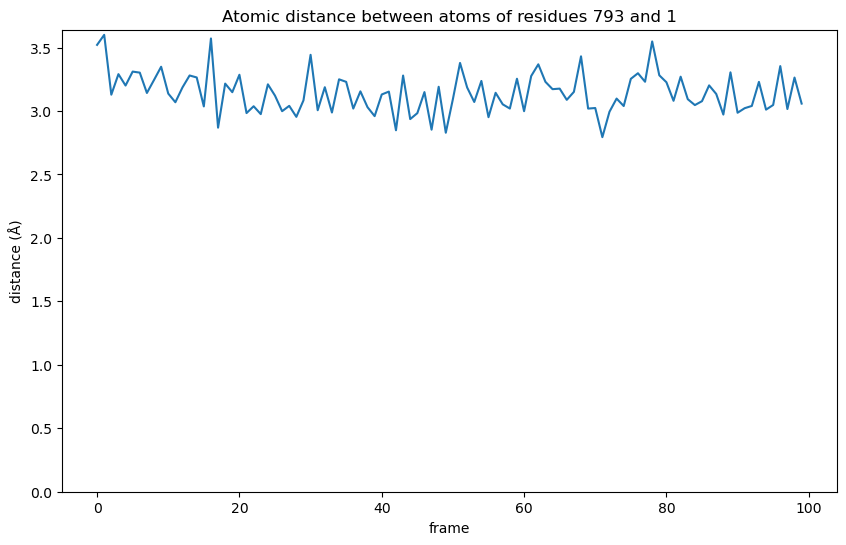

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.gca().set_ylim(bottom=0)
plt.ylabel("distance (Å)")
plt.xlabel("frame")
plt.title(
    f"Atomic distance between atoms of residues {protein_residue_id} and {ligand_id}"
)
plt.show()


## 氢键分析


In [25]:
hydrogen_name = "H"
hydrogens = md_universe.select_atoms(f"protein and name {hydrogen_name}")
print("Number of hydrogens selected:", len(hydrogens))
acceptors = md_universe.select_atoms(f"resname {ligand_name}")
print("Number of acceptors selected:", len(acceptors))


Number of hydrogens selected: 301
Number of acceptors selected: 63


In [26]:
def run_hydrogenbond_analysis(
    universe,
    donor_resid,
    donor_atom,
    hydrogen_atom,
    acceptor_resid,
    acceptor_atom,
    h_cutoff=1.2,
    a_cutoff=3.0,
    angle_cutoff=120,
):
    """
    执行选定原子组之间的氢键分析。
    以可读的格式化数据框形式返回数据。

    参数
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis的宇宙对象，表示模拟系统的整体。
    donor_resid: str
        包含供体原子的残基ID。
    donor_atom: str
        MDAnalysis宇宙中供体原子的名称。
    hydrogen_atom: str
        MDAnalysis宇宙中涉及的氢原子的名称。
    acceptor_resid: str
        包含受体原子的残基ID。
    acceptor_atom: str
        MDAnalysis宇宙中受体原子的名称。
    h_cutoff: float, optional
        用于寻找供体-氢对的距离截止值。
    a_cutoff: float, optional
        氢键的供体-受体距离截止值。
    angle_cutoff: int, optional
        氢键的D-H-A角度截止值。

    返回值
    -------
    bond : pandas.core.frame.DataFrame
        包含氢键信息的数据框。
    """

    # 设置并运行氢键分析 (HBA)
    hbonds = HBA(
        universe=universe,
        donors_sel="resid " + donor_resid + " and name " + donor_atom,
        hydrogens_sel="resid " + donor_resid + " and name " + hydrogen_atom,
        acceptors_sel="resid " + acceptor_resid + " and name " + acceptor_atom,
        d_h_cutoff=h_cutoff,
        d_a_cutoff=a_cutoff,
        d_h_a_angle_cutoff=angle_cutoff,
    )
    # 如果不设置这些参数，可能会导致选择错误的原子组或不正确的氢键标准，从而影响分析结果。

    hbonds.run()
    # 运行氢键分析。如果不运行此步骤，将无法获得任何氢键数据。

    # 提取氢键数据
    bond = pd.DataFrame(np.round(hbonds.results.hbonds, 2))
    # 将结果四舍五入到两位小数，并转换为数据框。如果不进行四舍五入，结果可能过于精确而难以阅读。

    # 命名列（根据MDAnalysis函数描述）
    bond.columns = [
        "frame",
        "donor_index",
        "hydrogen_index",
        "acceptor_index",
        "distance",
        "angle",
    ]

    # 将帧设置为索引
    bond["frame"] = bond["frame"].astype(int)
    bond.set_index("frame", inplace=True, drop=True)

    return bond


In [27]:
bond = run_hydrogenbond_analysis(
    md_universe,
    protein_residue_id,
    protein_atom_name,
    hydrogen_name,
    ligand_id,
    ligand_atom_name,
    h_cutoff=1.2,
    a_cutoff=5,
    angle_cutoff=120,
)
bond.head()


,donor_index,hydrogen_index,acceptor_index,distance,angle
frame,,,,,
0,1483.0,1484.0,5529.0,3.52,166.39
1,1483.0,1484.0,5529.0,3.60,145.63
2,1483.0,1484.0,5529.0,3.13,173.95
3,1483.0,1484.0,5529.0,3.29,151.99
4,1483.0,1484.0,5529.0,3.20,170.21


In [28]:
def plot_hydrogen_bond_over_time(bond):
    """
    Plot the distance and degree of a chosen hydrogen bond over time.
    Peaks in angle and dips in distance represent moments of strong binding.

    Parameters
    ----------
    bond: pandas.core.frame.DataFrame
        Hydrogen bond analysis data frame with named columns.
    """

    donor_index = bond.iloc[0].donor_index
    acceptor_index = bond.iloc[0].acceptor_index

    # add values for missing frames for gapless plotting
    bond = bond.reindex(np.arange(0, 99))

    # plot the data
    fig = plt.figure(figsize=(10, 6))
    distance = bond.distance.plot(
        title=f"H-Bond between donor {donor_index} and acceptor {acceptor_index}",
        style="o-",
        x="frame",
    )
    distance.set_ylabel("distance (Å)")
    distance.set_xlabel("frame")
    distance.set_ylim(bottom=0)
    angle = bond.angle.plot(secondary_y=True, style="o-", x="frame")
    angle.set_ylabel("angle (°)")
    angle.set_xlabel("frame")
    angle.set_ylim(bottom=0)
    fig.legend(
        loc="lower right", bbox_to_anchor=(1, 0), bbox_transform=distance.transAxes
    )
    plt.show()


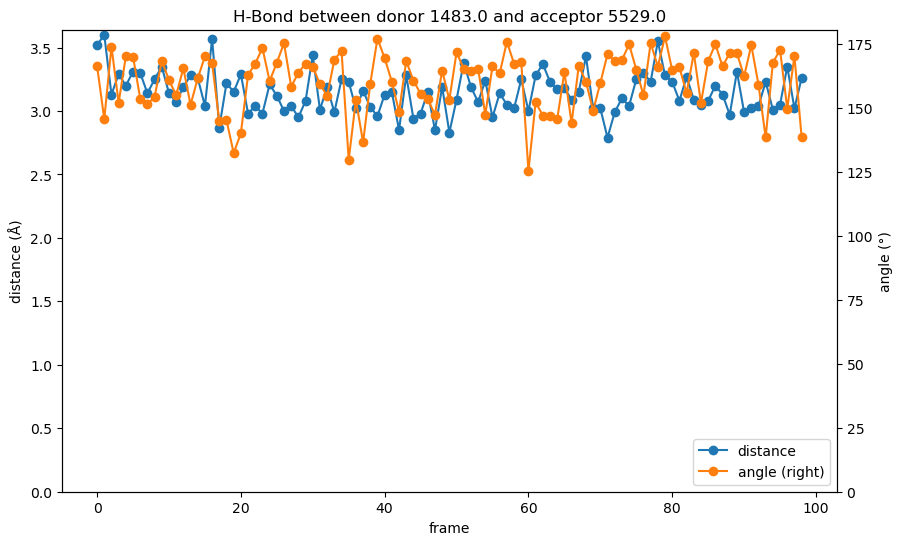

In [29]:
plot_hydrogen_bond_over_time(bond)


虽然氢键分析中的距离值与我们在上面的纯距离图中看到的相同，但与键角的结合提升了信息量。如前所述，在整个模拟过程中，距离处于氢键长度的上限，但键角始终接近 180° 并稳定了键。从分析中我们可以假设激酶铰链区骨架蛋氨酸之间的相互作用确实是配体结合的关键因素。

In [30]:
view_strong = nv.show_mdanalysis(md_universe)
view_strong.add_representation(
    "ball+stick", selection=f"protein and {protein_residue_id}"
)
view_strong.center(selection="ligand")
view_strong.frame = 71
view_strong


NGLWidget(frame=71, max_frame=99)

In [31]:
view_bad = nv.show_mdanalysis(md_universe)
view_bad.add_representation("ball+stick", selection=f"protein and {protein_residue_id}")
view_bad.center(selection="ligand")
view_bad.frame = 1
view_bad


NGLWidget(frame=1, max_frame=99)

氢键的强度通常受两个主要因素影响：供体和受体之间的距离，以及供体-氢-受体的角度。一般来说，氢键越短且角度越接近180°，其强度越大。

您认为哪种氢键最强？

A：供体受体距离 = 3.5 Å，供体氢受体角度 = 180°

B：供体受体距离 = 2.7 Å，供体氢受体角度 = 170°

C：供体受体距离 = 3.2 Å，供体氢受体角度 = 150°